# **Workshop VII** <br/> *Bayesian inference and decision trees*

In this exercise, please fill in the blanks that indicated by ...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import beta, norm, bernoulli

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from decimal import Decimal

import ID3 

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_18071/1071869909.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


---

## **1.** Bayesian Basics

This first exercise is meant as an introduction to the Bayesian framework. In particular, we will simulate a dataset of disease contamination. By simulating the dataset, we know the "true" parameter values and we can thus examine how accurate our inferences are. To get started, lets set up the simulation parameters.

In [2]:
# simulate a population of 100,000 people:
population = 100_000
prevalence = 0.01   # disease prevalence
sensitivity = 0.95  # true positive rate
specificity = 0.90  # true negative rate

# infectious status (1 = infected, 0 = not infected):
population_status = np.random.choice([1, 0], size=population, p=[prevalence, 1-prevalence])

# assign some fictitious test results to the population, based on our sensitivity and specificity:
test_results = np.zeros(population)
for i in range(population):
    if population_status[i] == 1:
        test_results[i] = np.random.choice([1, 0], p=[sensitivity, 1-sensitivity])
    else:
        test_results[i] = np.random.choice([1, 0], p=[1-specificity, specificity])


In [3]:
# create a dataframe to store the population data:
df = pd.DataFrame({'status': population_status, 'test_result': test_results})

#### Now, assuming that we have access to both the test results and the true results (the "status"), try to extract the Baysian probabilities from our simulated data, to find out posterior probability of being infected, given a positive test result. 

In [4]:
# calculate the Bayesian probabilities:
prior_probability = df['status'].mean()
likelihood = df[df['status'] == 1]['test_result'].mean()
probability_testing_positive = df['test_result'].mean()

print('Prior probability of infection:', prior_probability)
print('Likelihood of testing positive given infection:', likelihood)
print('Probability of testing positive:', probability_testing_positive)

Prior probability of infection: 0.00994
Likelihood of testing positive given infection: 0.9456740442655935
Probability of testing positive: 0.10884


#### Complete the function to calculate posterior, and them use it to get the posterior.

In [5]:
# Bayesian inference of Pr(status=1 | test=1)
def bayes_theorem(prior, likelihood, evidence):
    return (prior * likelihood) / evidence

pr_infected_given_positive = bayes_theorem(prior_probability, likelihood, probability_testing_positive)

# print posterior. which is (Pr(test=1 | status=1) * Pr(status=1)) / Pr(test=1)
print('Pr(status=1 | test=1) = ', pr_infected_given_positive) 

Pr(status=1 | test=1) =  0.08636530687247333


#### Interpret your finding.

This indicates that given a positive test for the disease, one has about 8% chance of actually having the disease. This is because the prevalence of the disease is low (1 in 100) relative to the prevalence of a false positive (1 in 10 at a specificity of 0.9). 

### If sensitivity is increased to 0.999, the specificity remains as original, what is the value of Pr(status=1 | test=1)?

#### If specificity is increased to 0.999, the sensitivity remains as original, what is the value of Pr(status=1 | test=1)?

#### Interprete your finding.

In [6]:
sensitivity = 0.999  # true positive rate
specificity = 0.90  # true negative rate

# assign some fictitious test results to the population, based on our sensitivity and specificity:
test_results = np.zeros(population)
for i in range(population):
    if population_status[i] == 1:
        test_results[i] = np.random.choice([1, 0], p=[sensitivity, 1-sensitivity])
    else:
        test_results[i] = np.random.choice([1, 0], p=[1-specificity, specificity])

df = pd.DataFrame({'status': population_status, 'test_result': test_results})
# calculate the Bayesian probabilities:
prior_probability = df['status'].mean()
likelihood = df[df['status'] == 1]['test_result'].mean()
probability_testing_positive = df['test_result'].mean()
pr_infected_given_positive = bayes_theorem(prior_probability, likelihood, probability_testing_positive)

print('Pr(status=1 | test=1) = ', pr_infected_given_positive) 

Pr(status=1 | test=1) =  0.09000181455271274


In [7]:
sensitivity = 0.95  # true positive rate
specificity = 0.999  # true negative rate

# assign some fictitious test results to the population, based on our sensitivity and specificity:
test_results = np.zeros(population)
for i in range(population):
    if population_status[i] == 1:
        test_results[i] = np.random.choice([1, 0], p=[sensitivity, 1-sensitivity])
    else:
        test_results[i] = np.random.choice([1, 0], p=[1-specificity, specificity])

df = pd.DataFrame({'status': population_status, 'test_result': test_results})
# calculate the Bayesian probabilities:
prior_probability = df['status'].mean()
likelihood = df[df['status'] == 1]['test_result'].mean()
probability_testing_positive = df['test_result'].mean()
pr_infected_given_positive = bayes_theorem(prior_probability, likelihood, probability_testing_positive)

print('Pr(status=1 | test=1) = ', pr_infected_given_positive) 

Pr(status=1 | test=1) =  0.9205103042198234


If the sensitivity is increased, the chance of getting a false positive given a healthy individual are unaffected, so it doesn’t change our value very much, there is still only a small chance of having the disease given a positive test.

However, if we increase the specificity a lot, then the chances of getting a false positive are much lower given a healthy individual. This means that a positive test is much more likely to indicate the disease.

---

## **2.** Dealing with Uncertainty

Of course, we are never able to take a peak into the true population parameters in real life. There will always be uncertainty. So far you have tried to quantify this uncertainty using frequentist techniques (i.e. maximum likelihood estimations, etc). Today you will quantify your uncertainty differently, using Bayesian statistics.

In the following, you will try to use Bayesian inference to go from data to results.

Now suppose we want to estimate the average weight of fish in a fishery farm. The real average weight of the fish is 2 kg. but we do not know this value beforehand. After a number of catches, we get data on the weight of a batch of fish. We know that the weights of the detected fish obeys a normal distribution around the mean value. How can we obtain the actual average weight of the fish from this data?

Let's start by adding some small data that obeys normal distribution. The mean is set to be 2 and the standard deviation is 1.

The Data generated from the following code:

#np.random.seed = 39

#sample_data = np.random.normal(2, 1, 30)

In [8]:
sample_data = np.array([ 1.64350291,  0.87752135,  3.05569158,  1.48274427,  1.4059861 ,
        3.93554187,  0.53890017,  2.12058382,  0.54360397,  2.25308647,
        2.71833633,  2.11059019,  0.90982909,  3.10162428,  2.99375448,
        1.9048221 ,  2.25047556,  2.60237373,  1.59678977,  2.00217239,
        1.3469326 ,  1.05712171,  0.32794892,  3.36094034, -0.42828078,
        1.27685994,  2.84693071,  3.21779923,  0.15080283,  2.29198599])

Now, because we cannot obtain the true value anymore, we set up a *prior distribution* to represent our uncertainty. 

Set up 4 priors to compare their effect on the posterior distribution later. Use the population value obtained in the previous part (i.e. approximately 0.0.1).

In [9]:
x_range = np.linspace(1,3,100)

# Prior 1: uncertain
prior1 = beta.pdf(x_range/3.0, 1, 1)/3.0

# Prior 2: somewhat uncertain
prior2 = beta.pdf(x_range/3.0, 1, 3)/3.0

# Prior 3: somewhat certain
prior3 = beta.pdf(x_range/3.0, 5, 3)/3.0

# Prior 4: certain
prior4 = beta.pdf(x_range/3.0, 30, 15)/3.0

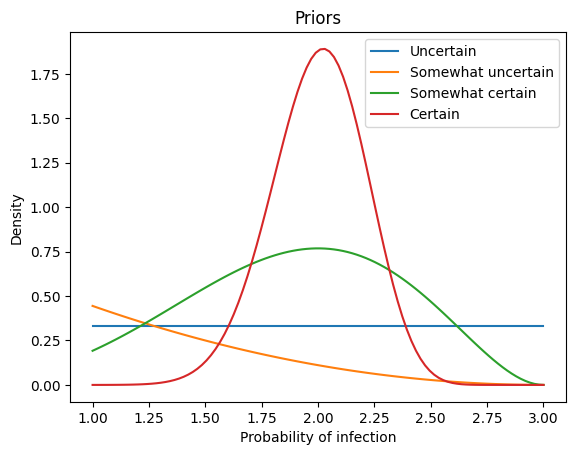

In [10]:
for prior, title in zip([prior1, prior2, prior3, prior4], ['Uncertain', 'Somewhat uncertain', 'Somewhat certain', 'Certain']):
    plt.plot(x_range, prior, label=title)

plt.xlabel('Probability of infection')
plt.ylabel('Density')
plt.title('Priors')
plt.legend()

#### Equiped with the prior distributions, we now form the likelihood.

In [11]:
# multiply log elements together
def multiply_elements(array):
    return np.log(array).sum()

# computing exponential function and normalization for large value
def largeExpNormalize(x_range,loglikelihoodlist):
    declikelihood = [Decimal(k).exp() for k in loglikelihoodlist]
    
    surface = Decimal(0)
    for i in range(1,len(x_range)):
        surface += Decimal(x_range[i]-x_range[i-1])*declikelihood[i]        
    
    mlh = [float(k/surface) for k in declikelihood]
    return mlh

# Gaussian pdf
def loglikelihood_function_normal(data,miu,sigma):
    return multiply_elements(norm.pdf(data, miu, sigma))

loglikelihoodlist = []
sigma = np.std(sample_data,ddof=1)
for miu in x_range:
    p = loglikelihood_function_normal(sample_data,miu,sigma)
    loglikelihoodlist.append(p)

mlh = largeExpNormalize(x_range,loglikelihoodlist)

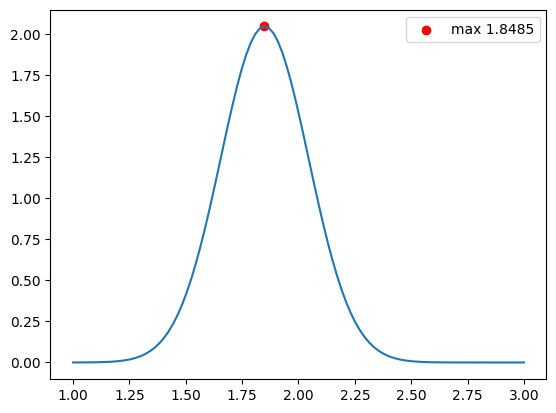

In [12]:
plt.plot(x_range, mlh)
plt.scatter(x_range[np.argmax(mlh)], mlh[np.argmax(mlh)], color='red',label="max %.4f"%(x_range[np.argmax(mlh)]))
plt.legend()

#### Compute the posterior with prior 1-4 and plot them. A function to compute the area under the curve is available.

In [13]:
def getSurface(x,y):
    surface = 0
    for i in range(1,len(x)):
        surface += (x[i]-x[i-1])*y[i]        
    return surface 

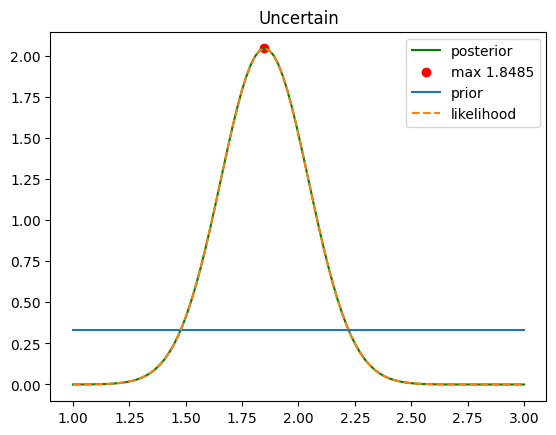

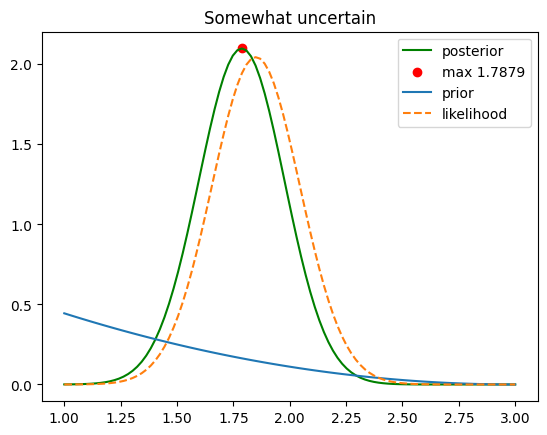

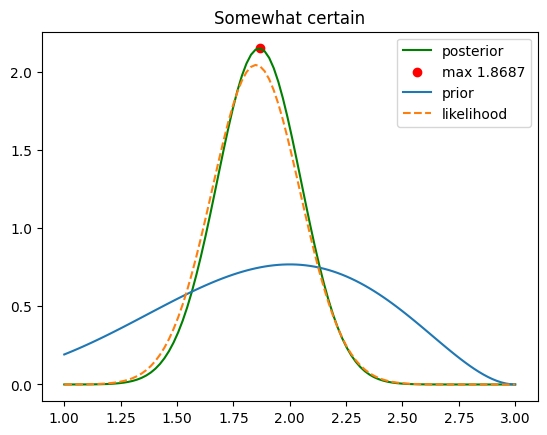

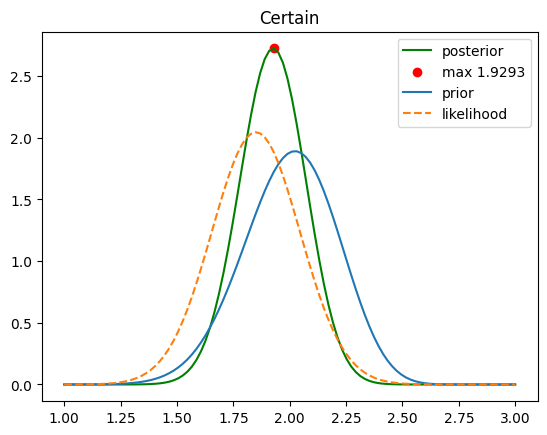

In [14]:
for prior, title in zip([prior1, prior2, prior3, prior4], ['Uncertain', 'Somewhat uncertain', 'Somewhat certain', 'Certain']):
    
    posterior = mlh * prior
    posterior /= getSurface(x_range, posterior)  # normalize

    plt.plot(x_range, posterior, 'g', label="posterior")
    plt.scatter(x_range[np.argmax(posterior)], posterior[np.argmax(posterior)], color='red',label="max %.4f"%(x_range[np.argmax(posterior)]))
    
    plt.plot(x_range, prior, label="prior")
    plt.plot(x_range, mlh, linestyle='--', label="likelihood")

    plt.legend()
    #plt.xlim(1.75,2.25)
    plt.title(title)
    plt.show()


Interpret the above plots.
The posterior is our evidence (the sample data from the fish we fished). The prior is an assumption we are making about the true distribution of fish weights. The more of the area under the curve they share, the more likely it is that the prior we assume is the one that generated the evidence. 

---

## 3. Decision Trees: ID3

In this section, you will use the provided `ID3.py` algorithm implementation to build and interpret a decision tree classifier. Apply this classifier to a real-world dataset, perform some predictions, and then analyze the decision tree's structure.

I will use my tree dataset to try to classify trees as  tall or not tall again.

In [15]:
# import data & add column names
df = pd.read_csv('data/clean_tree_data.csv')
data_n = 2000
df = df.sample(data_n, random_state=31415)
df.drop(['Unnamed: 0', 'tree_height_random'], axis=1, inplace=True)
df['is_tall'] = pd.Series(df['tree_height_fixed'] > 10).astype(int)
df.head()

,Boomhoogteklasseactueel,growth_ground,diameter_categories,tree_height_fixed,diameter,tree_admin,tree_municipality,age,species,species_group,tree_treatment,Naam_buurt,Naam_wijk,parked_cars_in_neighbourhood,is_tall
16058,f. 18 tot 24 m.,Gazon,"0,3 tot 0,5 m.",21.0,0.40,Recreatieschap Noord-Holland,Gemeente Amsterdam,59.0,Quercus robur cv.,Quercus,Boom niet vrij uitgroeiend,Osdorper Binnenpolder,Geuzenveld,856,1
8176,e. 15 tot 18 m.,Vaste planten,"0,2 tot 0,3 m.",16.5,0.25,R&E_VOR_Bomen,Gemeente Amsterdam,32.0,Ulmus minor 'Sarniensis',Ulmus,Boom niet vrij uitgroeiend,Bellamybuurt-Zuid,Bellamybuurt,318,1
4343,d. 12 tot 15 m.,Gazon,"0,2 tot 0,3 m.",13.5,0.25,R&E_VOR_Bomen,Gemeente Amsterdam,41.0,Tilia europaea,Tilia,Boom niet vrij uitgroeiend,Amstel III deel A/B-Noord,Amstel III/Bullewijk,16,1
16059,f. 18 tot 24 m.,Gazon,"0,3 tot 0,5 m.",21.0,0.40,Recreatieschap Noord-Holland,Gemeente Amsterdam,59.0,Fraxinus excelsior cv.,Fraxinus,Boom niet vrij uitgroeiend,Osdorper Binnenpolder,Geuzenveld,856,1
9412,f. 18 tot 24 m.,Bloemrijk gras,"0,5 tot 1 m.",21.0,0.75,R&E_VOR_Bomen,Gemeente Amsterdam,54.0,Quercus palustris,Quercus,Boom niet vrij uitgroeiend,Drieburg,Betondorp,397,1


Convert the continuous attributes into categorical ones. We need to do for attributes age, trestbps, chol, thalach, oldpeak, cp, sec, slope, thal and num. The first two are already done.

Note that there are many ways to do the discretization.

In [16]:
df_clean = pd.DataFrame({
#    'height': df['Boomhoogteklasseactueel'],
    'class': df['is_tall'],
    'diameter': df['diameter_categories'],
    'soil': df['growth_ground'],
    'admin': df['tree_admin'],
    'species': df['species'],
    'treatment': df['tree_treatment']
})

bins_age = [0, 5, 10, 20, 30, 40, 50, 75, 100, 250, 500]
labels_age = ['below 5', '5-10', '10-20', '20-30', '30-40', '40-50',
              '50-75', '75-100', '100-250', 'above 250']
df_clean['age'] = pd.cut(df['age'], bins=bins_age, labels=labels_age, include_lowest=True)

# Giving our class (whether tree is tall or not) more descriptive names
class_replacements = {0: 'Small tree', 1: 'Tall tree'}
df_clean['class'] = df_clean['class'].replace(class_replacements)

# Turn the rest into string
df_clean = df_clean.astype(str)

# show
print([type(df_clean.iloc[0,i]) for i in range(len(df_clean.columns))])
df_clean.head()

[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


,class,diameter,soil,admin,species,treatment,age
16058,Tall tree,"0,3 tot 0,5 m.",Gazon,Recreatieschap Noord-Holland,Quercus robur cv.,Boom niet vrij uitgroeiend,50-75
8176,Tall tree,"0,2 tot 0,3 m.",Vaste planten,R&E_VOR_Bomen,Ulmus minor 'Sarniensis',Boom niet vrij uitgroeiend,30-40
4343,Tall tree,"0,2 tot 0,3 m.",Gazon,R&E_VOR_Bomen,Tilia europaea,Boom niet vrij uitgroeiend,40-50
16059,Tall tree,"0,3 tot 0,5 m.",Gazon,Recreatieschap Noord-Holland,Fraxinus excelsior cv.,Boom niet vrij uitgroeiend,50-75
9412,Tall tree,"0,5 tot 1 m.",Bloemrijk gras,R&E_VOR_Bomen,Quercus palustris,Boom niet vrij uitgroeiend,50-75


#### Split the dataset into training and test sets.

In [17]:

# Split the DataFrame into features and target
X = df_clean.drop('class', axis=1)  # Drop the target
y = df_clean['class']  # Target column

# Convert the target back into a DataFrame and name the column 'class' for compatibility
y = pd.DataFrame(y, columns=['class'])

# Combine X and y for the ID3 algorithm
data_for_id3 = pd.concat([X, y], axis=1)

# Split the dataset into training and test sets
data_train, data_test = train_test_split(data_for_id3, test_size=0.2, random_state=31415)

#### Now, using the provided ID3 algorithm, construct a decision tree using the training set.

In [18]:
features = list(data_train.columns[:-1])

# Construct the decision tree
decision_tree = ID3.ID3(data_train, data_train, features, 'class')

In [19]:
# Print the tree to get an idea of its structure
ID3.print_tree(decision_tree)

species
|--- Acer campestre
|   |--- age
|   |   |--- 10-20
|   |   |   |--- Tall tree
|   |   |--- 20-30
|   |   |   |--- Small tree
|   |   |--- 30-40
|   |   |   |--- diameter
|   |   |   |   |--- 0,1 tot 0,2 m.
|   |   |   |   |   |--- Small tree
|   |   |   |   |--- 0,2 tot 0,3 m.
|   |   |   |   |   |--- soil
|   |   |   |   |   |   |--- Bloemrijk gras
|   |   |   |   |   |   |   |--- Small tree
|   |   |   |   |   |   |--- Bomen en struikvormers
|   |   |   |   |   |   |   |--- treatment
|   |   |   |   |   |   |   |   |--- Boom niet vrij uitgroeiend
|   |   |   |   |   |   |   |   |   |--- Tall tree
|   |   |   |   |   |   |   |   |--- Boom vrij uitgroeiend
|   |   |   |   |   |   |   |   |   |--- admin
|   |   |   |   |   |   |   |   |   |   |--- R&E_VOR_Bomen
|   |   |   |   |   |   |   |   |   |   |   |--- Tall tree
|   |   |   |   |--- 0,3 tot 0,5 m.
|   |   |   |   |   |--- Tall tree
|   |   |--- 40-50
|   |   |   |--- Tall tree
|   |   |--- 5-10
|   |   |   |--- Tall tree

#### Implement a code to use the constructed decision tree to make predictions on the test set.

In [20]:
# The 'class' column should not be included in the features of the test set
test_features = data_test.drop('class', axis=1)

# Use the new prediction function to get predictions for the test set
# default value is used when no result is obtained
# tall tree is the most common outcome 
predictions = ID3.predictDataset(test_features, decision_tree, default="Tall tree")

# Compare the predictions with the actual values
actual_values = data_test['class'].tolist()
comparison = pd.DataFrame({'Actual': actual_values, 'Predicted': predictions})

print(comparison)

         Actual   Predicted
0    Small tree  Small tree
1    Small tree   Tall tree
2    Small tree   Tall tree
3     Tall tree   Tall tree
4    Small tree  Small tree
..          ...         ...
395   Tall tree  Small tree
396   Tall tree   Tall tree
397   Tall tree   Tall tree
398   Tall tree   Tall tree
399  Small tree  Small tree

[400 rows x 2 columns]


Accuracy: 0.8250


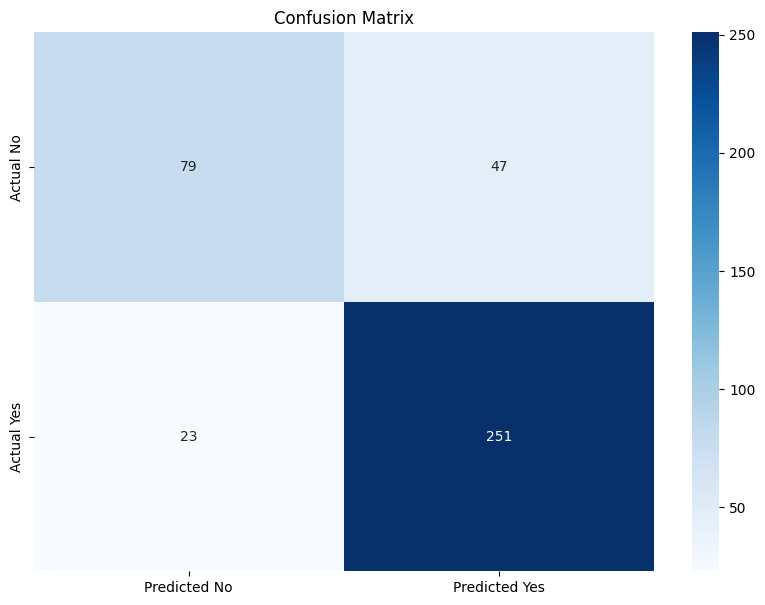

In [21]:
# Lets visualize the accuracy!
accuracy = accuracy_score(actual_values, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(actual_values, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
#plt.xlabel('Predicted Label')
#plt.ylabel('True Label')
plt.show()

Finally, interpret your decision tree:

In [22]:
ID3.print_tree(decision_tree)

species
|--- Acer campestre
|   |--- age
|   |   |--- 10-20
|   |   |   |--- Tall tree
|   |   |--- 20-30
|   |   |   |--- Small tree
|   |   |--- 30-40
|   |   |   |--- diameter
|   |   |   |   |--- 0,1 tot 0,2 m.
|   |   |   |   |   |--- Small tree
|   |   |   |   |--- 0,2 tot 0,3 m.
|   |   |   |   |   |--- soil
|   |   |   |   |   |   |--- Bloemrijk gras
|   |   |   |   |   |   |   |--- Small tree
|   |   |   |   |   |   |--- Bomen en struikvormers
|   |   |   |   |   |   |   |--- treatment
|   |   |   |   |   |   |   |   |--- Boom niet vrij uitgroeiend
|   |   |   |   |   |   |   |   |   |--- Tall tree
|   |   |   |   |   |   |   |   |--- Boom vrij uitgroeiend
|   |   |   |   |   |   |   |   |   |--- admin
|   |   |   |   |   |   |   |   |   |   |--- R&E_VOR_Bomen
|   |   |   |   |   |   |   |   |   |   |   |--- Tall tree
|   |   |   |   |--- 0,3 tot 0,5 m.
|   |   |   |   |   |--- Tall tree
|   |   |--- 40-50
|   |   |   |--- Tall tree
|   |   |--- 5-10
|   |   |   |--- Tall tree

If I'm not mistaken, this represents different paths that we can take with different attributes. So "for this species, of this age, of this treatment... ... we get this result, now let's try with this other attribute". The closer to the root an attribute is, the more important it is to the decision of which class it belongs to. The leaf nodes (the ones that don't lead to other nodes) represent the outcome that a tree gets according to its decision path.

---

## **4.** Decision Trees: CART

This time we try to use the python build-in function, CART.

For this method, we don't need to categorize our attributes. While the non-categorical attributes works better.

In [23]:
df.columns

Index(['Boomhoogteklasseactueel', 'growth_ground', 'diameter_categories',
       'tree_height_fixed', 'diameter', 'tree_admin', 'tree_municipality',
       'age', 'species', 'species_group', 'tree_treatment', 'Naam_buurt',
       'Naam_wijk', 'parked_cars_in_neighbourhood', 'is_tall'],
      dtype='object')

In [24]:
# Reload the data
df_cart = pd.DataFrame({
    'num': df['is_tall'],
    # 'height': df['tree_height_fixed'],
    # 'growth_ground': df['growth_ground'],
    'diameter': df['diameter'],
    # 'tree_admin': df['tree_admin'],
    'age': df['age'],
    # 'species': df['species'],
    'parked_cars': df['parked_cars_in_neighbourhood'],
})
    
X = df_cart.drop('num', axis=1)  # features
y = df_cart['num']  # target

# Split the dataset into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print([type(X_train.iloc[0,i]) for i in range(len(X_train.columns))])

[<class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.int64'>]


#### Create a decision tree and fit the data into it.

In [25]:
# Create a DecisionTreeClassifier object
cart_model = DecisionTreeClassifier(random_state=31415)

# Fit the model to the training data
cart_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=31415)

#### Now let's make some predictions on the test set to evaluate performance:

Accuracy: 0.7950


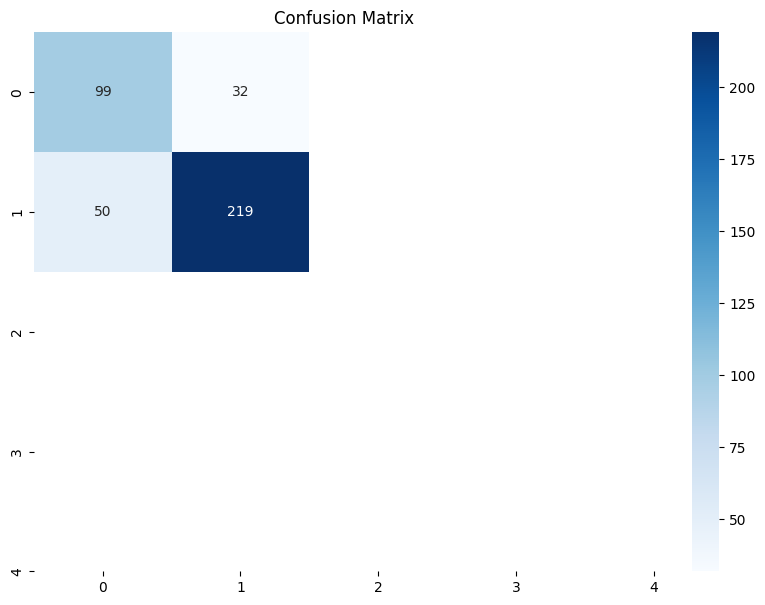

In [26]:
# Making predictions
predictions = cart_model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.show()

Finally, we visualize the decision tree:

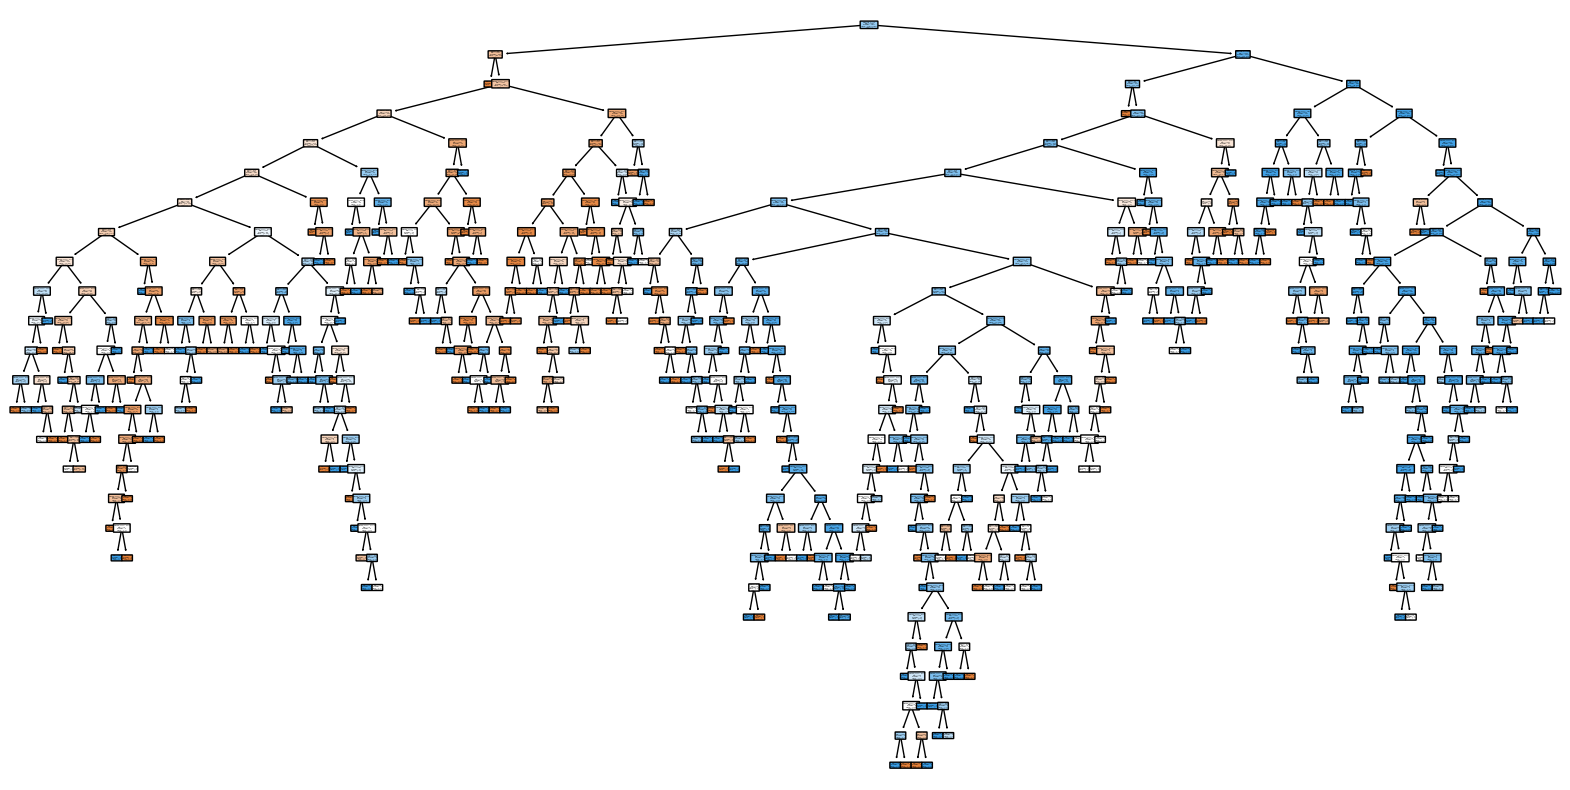

In [27]:
plt.figure(figsize=(20,10))
plot_tree(cart_model, 
          filled=True, 
          rounded=True, 
          class_names=['0', '1', '2', '3', '4'],  # Update class names as appropriate
          feature_names=list(X_train.columns))       # Ensure X_train.columns is accessible
plt.show()

#### Please interpret the results, try to answer the following:

- How well did both models predict tree tallness?
- Describe the model's performance in terms of false positives, false negatives, true positives, and true negatives.
- Analyze the tree to determine the most important features and decision paths leading to heart disease prediction.

Both models seem to get more true positives than true negatives. This is probably due to the fact that in general, there are more tall trees than not. Still, both models perform better than the null inforimation rate (which is around 0.7). 

Looking at the tree printout, it seems that species is the single most important feature that leads to a tall tree prediction, with age closely following. 